Requires graphviz

1. [Decision trees](#sec1)
    1. [The Iris dataset](#sec1-1)
    2. [What is a decision tree?](#sec1-2)
    3. [Growing decision trees](#sec1-3)
    4. [A note on the Entropy and the Gini index](#sec1-4)
    5. [Generalizing the splitting criterion](#sec1-5)
    6. [Practicing with trees](#sec1-6)
    7. [Variability of decision trees](#sec1-7)
    8. [Conclusion on Decision Trees](#sec1-8)
2. [Bagging](#sec2)
    1. [The bootstrap (statistics)](#sec2-1)
    2. [Bootstraping in Machine Learning](#sec2-2)
    3. [Why does Bagging work?](#sec2-3)
    4. [Bagging in practice](#sec2-4)
3. [Random Forests](#sec3)
4. [Examples](#sec4)
    1. [Spam or ham?](#sec4-1)
    2. [NIST](#sec4-2)

# 1. <a id="sec1"></a>Decision trees

## <a id="sec1-1"></a>1.1 The Iris dataset.
- 150 Iris flowers
- 3 species (labels)
- 4 morphologic features: petal and sepal width and length
- 50 examples in each class

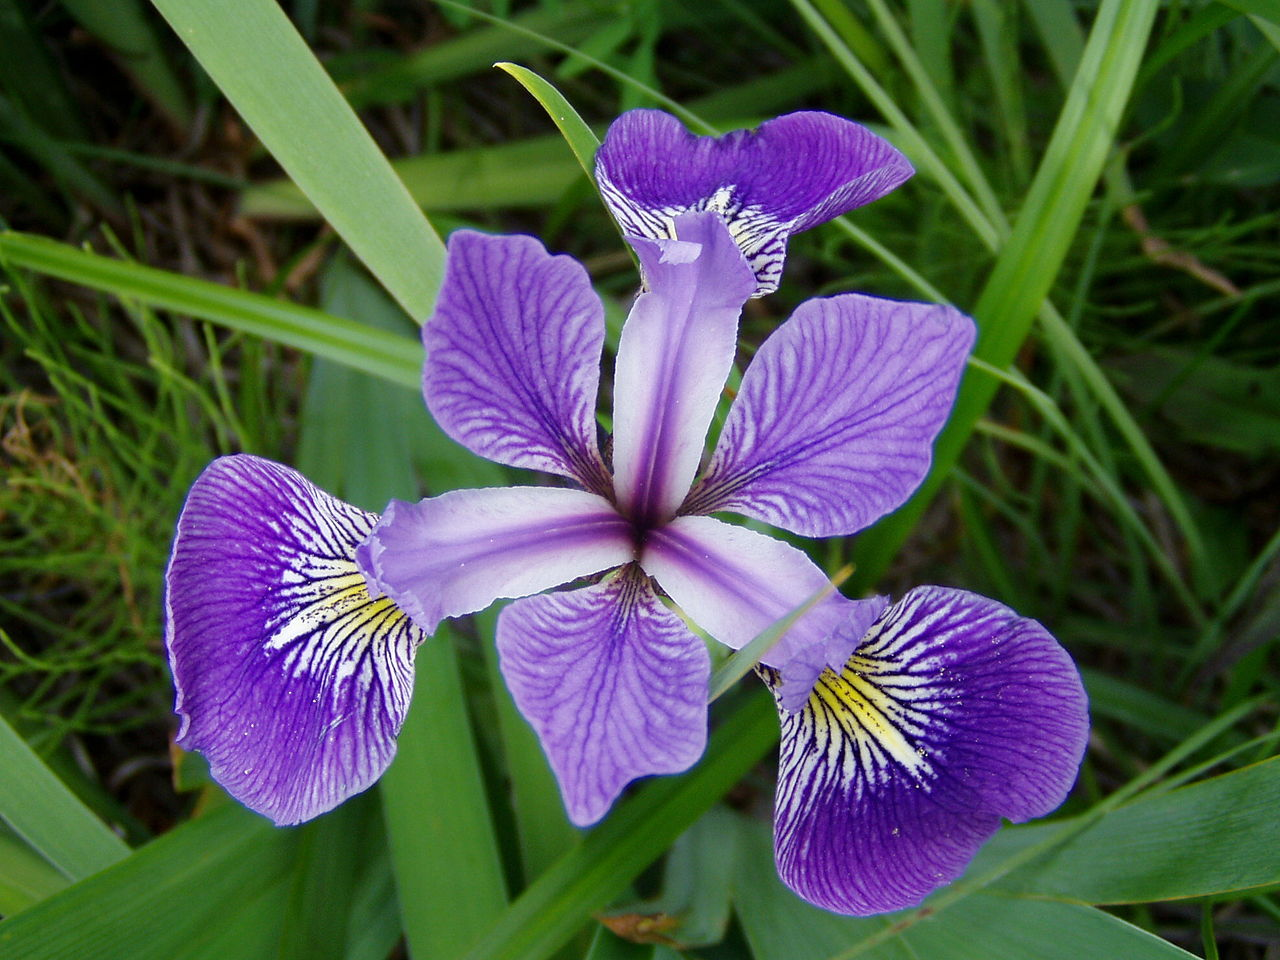

In [1]:
from sklearn import datasets

iris = datasets.load_iris()
print(iris.data.shape)
print(iris.target.shape)
print(iris.target_names)
print(iris.feature_names)
print("\n",iris.DESCR)

(150, 4)
(150,)
['setosa' 'versicolor' 'virginica']
['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']

 Iris Plants Database

Notes
-----
Data Set Characteristics:
    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5

## <a id="sec1-2"></a> 1.2 What is a decision tree?

**Hierarchical description of data based on logical (binary) questions**.

Ingredients:
- Nodes<br>
Each node contains a **test** on the features which **partitions** the data.
- Edges<br>
The outcome of a node's test leads to one of its child edges.
- Leaves<br>
A terminal node, or leaf, holds a **decision value** for the output variable.
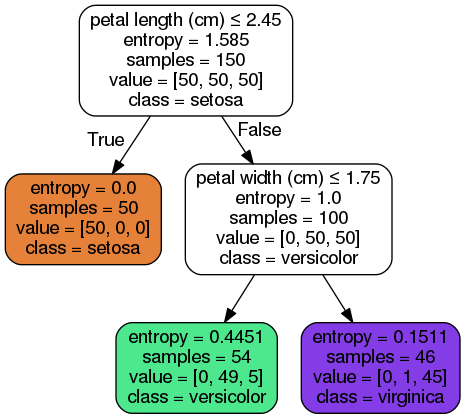

## <a id="sec1-3"></a>1.3 Growing decision trees

Training Set $T$, attributes $x_1,\ldots, x_p$

<div class= "alert alert-success">
**FormTree($T$)**<br>
<ol>
<li> Find best split $(j, s)$ over $T$ // Which criterion?
<li> If $(j, s) = \emptyset$, 
    <ul>
    <li>  node = FormLeaf(T) // Which value for the leaf?
    </ul>
<li> Else
    <ul>
    <li> node = $(j, s)$
    <li> split $T$ according to $(j, s)$ into $(T1, T2)$
    <li> append FormTree($T1$) to node // Recursive call
    <li> append FormTree($T2$) to node
    </ul>
<li> Return node
</ol>
</div>

**Classification: splitting criterion**

Choose split $(j,s)$ that maximizes the entropy (information) gain:
$$N_1 \sum\limits_{k=1}^K \hat{p}_{1k} \log \hat{p}_{1k} + N_2 \sum\limits_{k=1}^K \hat{p}_{2k} \log \hat{p}_{2k}$$
with $N_m$: number of examples in node $m$ and $p_{mk}$: proportion of class $k$ in node $m$

Alternate criterion: maximize the Gini index gain.
$$N_1 \sum\limits_{k=1}^K \hat{p}_{1k} \left(1-\hat{p}_{1k}\right) + N_2 \sum\limits_{k=1}^K \hat{p}_{2k} \left( 1- \hat{p}_{2k} \right)$$

**Classification: value of a leaf node**
- majority class.

**Regression: splitting criterion**

We want to minimize the **sum of squares** error in a leaf node:
$$\sum_{i=1}^{N_m} \left(y_i - \hat{f}(x_i)\right)^2$$
Where $\hat{f}(x_i)$ is the prediction in $x_i$. For simplicity, we take constant node-wise predictions $\hat{f}(x_i)= \hat{y}_i$. We introduce the node impurity measure as the mean square error:
$$Q_m = \frac{1}{N_m} \sum_{i=1}^{N_m} \left(y_i - \hat{y}_i\right)^2 $$
The best split is then the one that minimizes
$$N_1 Q_1 + N_2 Q_2$$

**Regression: value of a leaf node**
- average

Alternatives (but imply to change the splitting criterion):
- median
- extreme values
- B-spline

## <a id="sec1-4"></a> 1.4 A note on the Entropy and the Gini index

Suppose a set of samples $T=\left\{(x,y)\right\}$ where $y\in \{0;1\}$ and a constant value for $x$. The labels $y$ give some class information on $x$. One relevant question is "how much useful information is there in $T$?".

- For example, if half of the examples have label "0" and the other half has label "1", then there is no real useful information in $T$.
- On the other hand, if all the examples have the same label, then $T$ is very informative regarding the real class of $x$.

Intuitively, a measure of "disorder" in a training set is an opposite measure of "information". That's what Shannon theorized in his Information theory.

A measure of disorder is the (binary) entropy of a set of bits. Suppose $p$ is the probability of class "0":
$$H(p) = -p \log_2(p) - (1-p)\log_2(1-p)$$

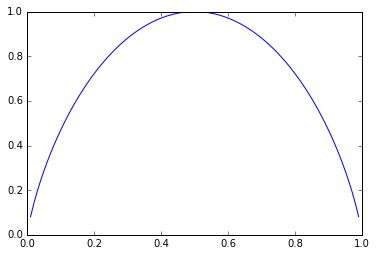

When building a tree, we want to choose each split so that it increases the overall information. Hence we want to decrease the overall entropy. Since entropy is additive, if the subscript "0" refers of a node and the subscripts "1" and "2" to its children after a split, we want $N_0 H_0 > N_1 H_1 + N_2 H_2$.

The Gini index expresses somehow the same idea. It was introduced by Gini (a sociologist and statistician) in 1936 to describe inequalities of income or wealth within a population. For $K$ classes, it is written:
$$\sum_{k=1}^K p_k(1-p_k)$$

To get an intuition of why this is a measure of inequality, suppose training set $T=\left\{(x,y)\right\}$ with only two classes $\{0;1\}$. Suppose you pick an individuals $x$ at random in $T$ and then you pick a class $y$ at random in $T$ again. What is the probability that $y$ is not the label of $x$?
$$p(1-p) + (1-p)(1-(1-p))$$

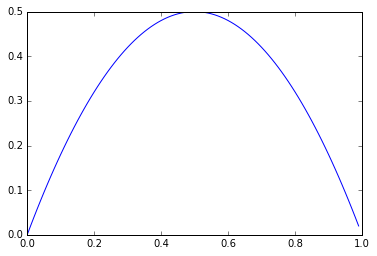

## <a id="sec1-5"></a> 1.5 Generalizing the splitting criterion

Overall it is a matter of decreasing an impurity measure in the current node. This impurity measure is the **fitness** criterion our tree tries to (locally) minimize: entropy, Gini index, mean square error.

## <a id="sec1-6"></a> 1.6 Practicing with trees

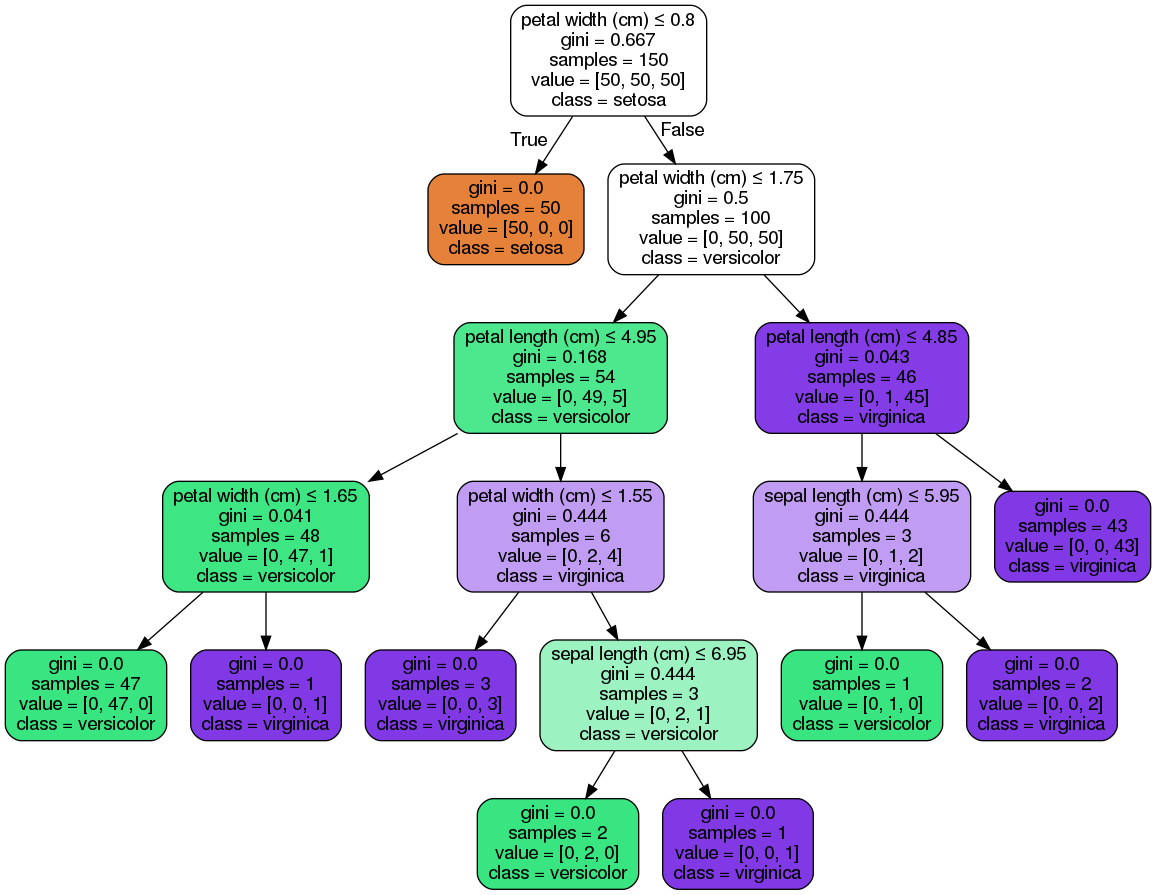

In [2]:
from sklearn import tree
from os import system
from IPython.display import Image

iris_dt = tree.DecisionTreeClassifier()
iris_dt.fit(iris.data, iris.target)

def disp_iris_tree(filename, treename):
    dotfile = open(filename+'.dot', 'w')
    tree.export_graphviz(treename, 
                         out_file = dotfile, 
                         feature_names = iris.feature_names,
                         class_names=iris.target_names,  
                         filled=True,
                         rounded=True,  
                         special_characters=True)
    dotfile.close()
    system("dot -Tpng "+filename+".dot -o "+filename+".png")
    return Image(filename+'.png')
   
disp_iris_tree('iris_dt',iris_dt)

Let's try to limit the depth of the tree to preserve the generalization error.

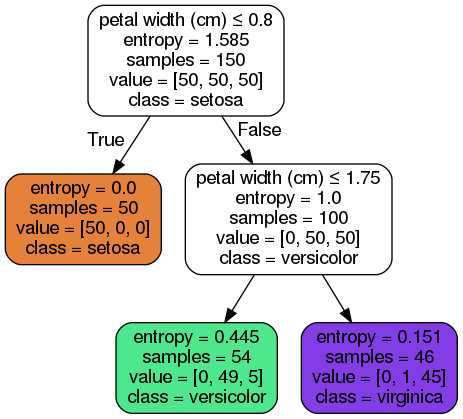

In [3]:
iris_dt2 = tree.DecisionTreeClassifier(criterion = 'entropy', max_depth=2)
iris_dt2.fit(iris.data, iris.target)
disp_iris_tree('iris_dt2',iris_dt2)

Let's try on 2D complex data.

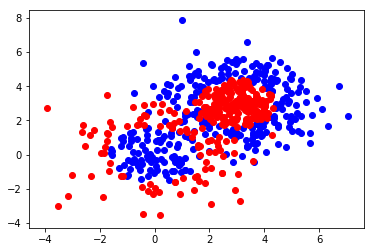

In [4]:
import numpy as np
from sklearn.utils import shuffle
%matplotlib inline
import matplotlib.pyplot as plt

def gen_data(seed):
    X1, y1 = datasets.make_gaussian_quantiles(cov=2.,
                                 n_samples=300, n_features=2,
                                 n_classes=2, random_state=seed)
    X2, y2 = datasets.make_gaussian_quantiles(mean=(3, 3), cov=1.5,
                                 n_samples=700, n_features=2,
                                 n_classes=2, random_state=seed)
    X = np.concatenate((X1, X2))
    y = np.concatenate((y1, - y2 + 1))
    y = 2*y-1
    X, y = shuffle(X, y)
    return X, y

X,y = gen_data(1)
Xtest,X = np.split(X,[400])
ytest,y = np.split(y,[400])

Xblue = X[y==-1]
Xred = X[y==1]
plt.figure()
plt.scatter(Xblue[:,0],Xblue[:,1],c='b')
_=plt.scatter(Xred[:,0],Xred[:,1],c='r')

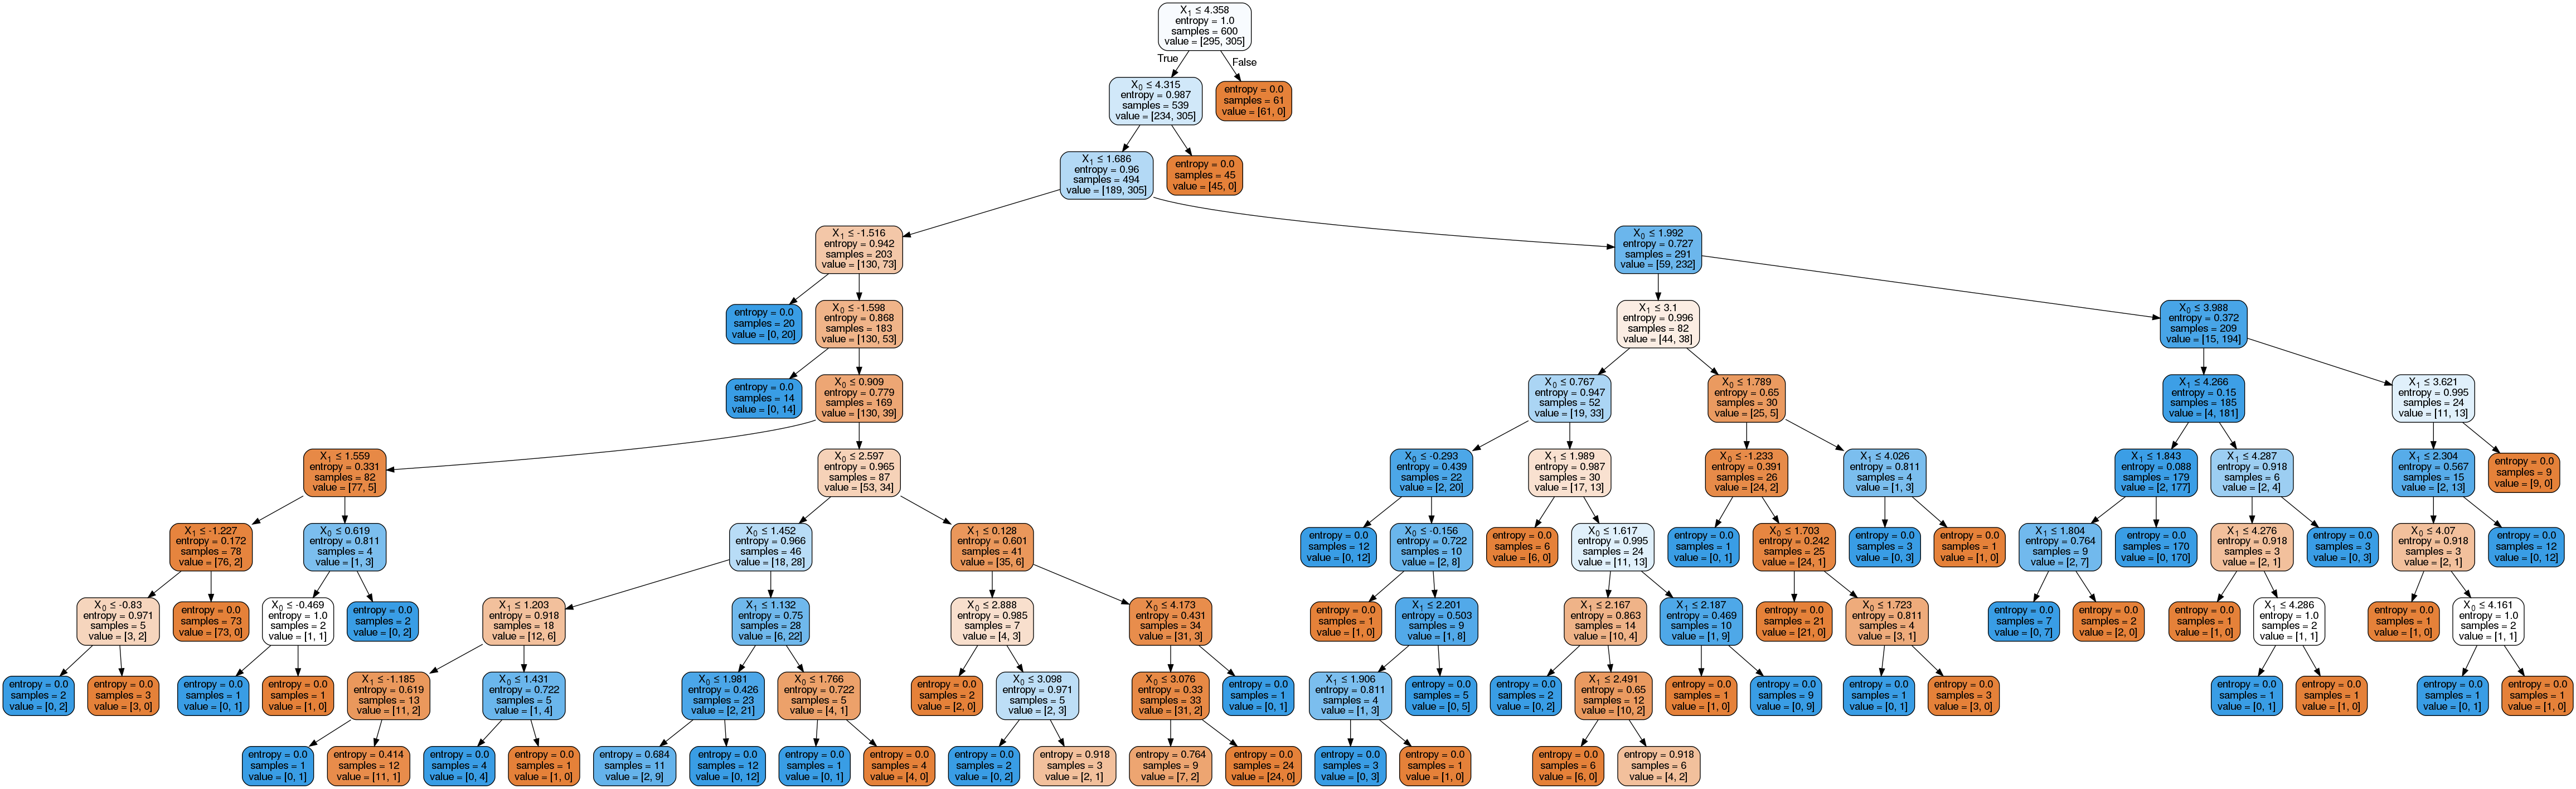

In [5]:
# Change max_depth parameter to 10
dt1 = tree.DecisionTreeClassifier(criterion='entropy',max_depth=10)
dt1.fit(X,y)

def disp_tree(filename, treename):
    dotfile = open(filename+'.dot', 'w')
    tree.export_graphviz(treename, 
                         out_file = dotfile,
                         filled=True,
                         rounded=True,  
                         special_characters=True)
    dotfile.close()
    system("dot -Tpng "+filename+".dot -o "+filename+".png")
    return Image(filename+'.png')

disp_tree('dt1',dt1)

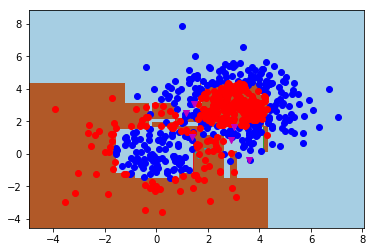

Training error: 0.0133333
Generalization error: 0.0775


In [6]:
def plot_decision_boundary_tree(t, X, y):
    plot_step = 0.02
    x0_min, x0_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x1_min, x1_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx0, xx1 = np.meshgrid(np.arange(x0_min, x0_max, plot_step), np.arange(x1_min, x1_max, plot_step))
    yypred = t.predict(np.c_[xx0.ravel(),xx1.ravel()])
    yypred = yypred.reshape(xx0.shape)
    plt.figure()
    plt.contourf(xx0, xx1, yypred, cmap=plt.cm.Paired)
    y_pred = t.predict(X)
    Xblue_good = X[np.equal(y,-1)*np.equal(y,y_pred)]
    Xblue_bad  = X[np.equal(y,-1)*np.not_equal(y,y_pred)]
    Xred_good  = X[np.equal(y,1)*np.equal(y,y_pred)]
    Xred_bad   = X[np.equal(y,1)*np.not_equal(y,y_pred)]
    plt.scatter(Xblue_good[:,0],Xblue_good[:,1],c='b')
    plt.scatter(Xblue_bad[:,0],Xblue_bad[:,1],c='c',marker='v')
    plt.scatter(Xred_good[:,0],Xred_good[:,1],c='r')
    plt.scatter(Xred_bad[:,0],Xred_bad[:,1],c='m',marker='v')
    plt.show()

plot_decision_boundary_tree(dt1, X, y)
print("Training error: %g"%(1-dt1.score(X,y)))
print("Generalization error: %g"%(1-dt1.score(Xtest,ytest)))

## <a id="sec1-7"></a> 1.7 Variability of decision trees
Let's generate different data sets from the same distribution and compare how different the classification trees are.

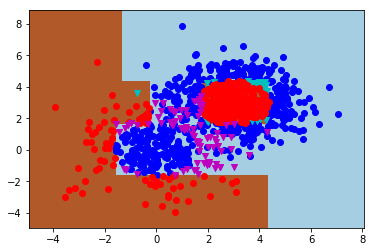

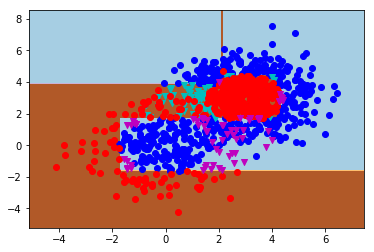

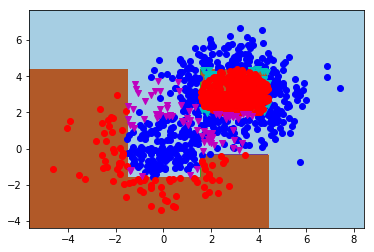

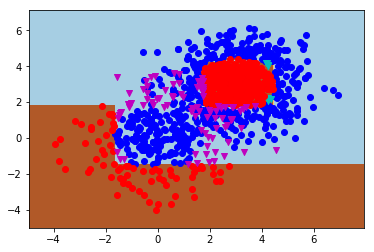

In [7]:
# example 2
X,y = gen_data(1)
dt1 = tree.DecisionTreeClassifier(criterion='entropy',max_depth=5)
dt1.fit(X,y)
plot_decision_boundary_tree(dt1, X, y)

# example 2
X,y = gen_data(3)
dt1 = tree.DecisionTreeClassifier(criterion='entropy',max_depth=5)
dt1.fit(X,y)
plot_decision_boundary_tree(dt1, X, y)

# example 3
X,y = gen_data(5)
dt1 = tree.DecisionTreeClassifier(criterion='entropy',max_depth=5)
dt1.fit(X,y)
plot_decision_boundary_tree(dt1, X, y)

# example 4
X,y = gen_data(9)
dt1 = tree.DecisionTreeClassifier(criterion='entropy',max_depth=5)
dt1.fit(X,y)
plot_decision_boundary_tree(dt1, X, y)

## <a id="sec1-7"></a>  1.8 Conclusion on Decision Trees

Additional topics:
- Pruning decision trees?
- Handling missing values?
- Preprocessing data? PCA and trees?

Summary:
- Very limited representation power (hypercubes).
- Very sensitive to overfitting.
- **Very dependent on the input data.**
- Easy to read and explain.
- Learning the tree has complexity linear in p.
- No margin or performance guarantees.
- Often used with ensemble methods (Boosting, Bagging).

# <a id="sec2"></a> 2. Bagging

Trees are a higly variable predictor: slight changes in input data $\Rightarrow$ huge changes in prediction.

It seems rather like a weakness, let's use that as a strength.

## <a id="sec2-1"></a> 2.1 The bootstrap (statistics)

Bootstrapping: a general method in Statistics to reduce prediction variance.

**The formal problem:**

Suppose a set of examples $\mathbf{x}$ of size $n$.<br>
Suppose one wants to evaluate a statistic $\theta$ with an estimator $\widehat{\theta}$.

To reduce $\widehat{\theta}$'s variance one needs more data points in $\mathbf{x}$ but they are not available.

**Proposed solution:**

- Simulate the distribution that generated $\mathbf{x}$ by drawing $n$ samples from $\mathbf{x}$ with replacement.
- Evaluate $\widehat{\theta}$ on this new sample set of size $n$.
- Repeat many times.
- Average the results.

**The algorithm:**

For $b=1$ to $B$
1. Bootstrap sample: obtain $\mathbf{x}^b$ by sampling from $\mathbf{x}$ with replacement.
2. Compute $\hat{\theta}^b$ from $\mathbf{x}^b$

Return $\hat{\theta} = \frac{1}{B} \sum\limits_{b=1}^B \hat{\theta}^b$

**Origin of the "bootstrap" name:**
- Popular saying: to pull oneself up by one's own bootstraps.
- Münchhausen (Rudolf E. Raspe)<br> pulls himself out of a mire by his own hair.
- $[$French$]$ Méthode de Cyrano (E. Rostand)<br> Flies to the moon by 7 different ways, including throwing a magnet upwards.
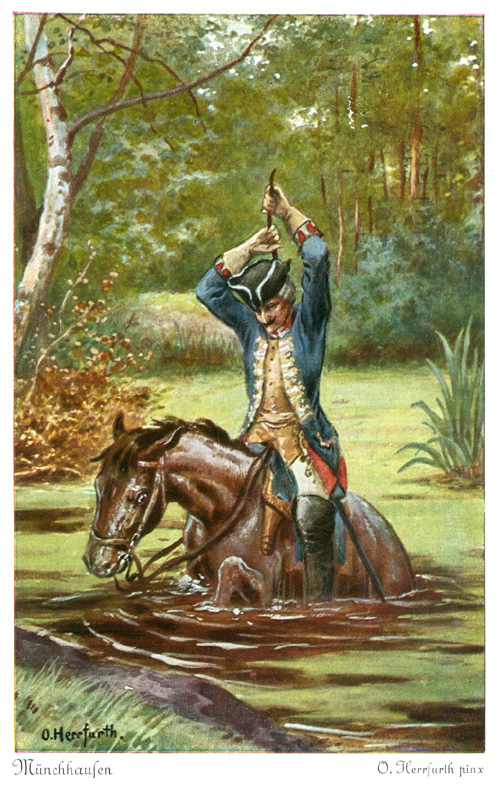

## <a id="sec2-2"></a> 2.2 Bootstraping in Machine Learning

Training set: $\mathcal{T}=\left\{(x_i,y_i)\right\}_{i=1..N}$.<br>
Predictor $\varphi(x)$ trained on $\mathcal{T}$.

Bootstrap replicates of $\mathcal{T}$ to build a better predictor $\varphi_B$?<br>
$\rightarrow$ Idea of Bagging (**B**ootstrap **agg**regat**ing**)

**Bagging in a nutshell:**

For $b=1$ to $B$
1. Take bootstrap replicate $\mathcal{T}^b$ of $\mathcal{T}$
2. Train $\varphi^b$ on $\mathcal{T}^b$

Return $\varphi_B: x\mapsto \arg\max\limits_{j} \sum\limits_{b=1}^B I(\varphi^b(x) = j)$ (majority vote).

## <a id="sec2-3"></a> 2.3 Why does Bagging work?

Let:
- $\varphi$ be the base classifier<br>
(generalization error $e$).
- $\varphi_B$ be the Bagging estimator built with Bootstrap samples<br>
(generalization error $e_B$).
- $\varphi_A$ be the aggregate estimator averaging over all possible training sets<br>
(generalization error $e_A$).

In practice, we never get $\varphi_A$.

<div class="alert alert-success">**Key results:**<br>
*1st result:* $\varphi_A$ is always at least as good as $\varphi$; $e_A \leq e$<br>
<br>
*2nd result:* The highest the variance of $\varphi$ across training sets $\mathcal{T}$, the more improvement $\varphi_A$ produces.<br>
<br>
*3rd result:* $\varphi_B$ only approximates $\varphi_A$ so $e_A \leq e_B$
</div>

Consequences:
- If $\varphi$ highly variable w.r.t. $\mathcal{T}$, $\varphi_B$ improves on $\varphi$ through aggregation.
- But if $\varphi$ is rather stable w.r.t. $\mathcal{T}$, $e_A\approx e$ and since $\varphi_B$ approximates $\varphi_A$, $e_B$ might be greater than $e$.

**So it does not always work?**

Actually, no, it does not always work.<br>
Bagging should be used to transform highly variable predictors $\varphi$ into a more accurate averaged commitee $\varphi_B$.

Examples of $\varphi$ that Bagging improves:<br>
$\rightarrow$ Trees, Neural Networks.<br>
Examples of $\varphi$ that Bagging does not improve much (or degrades):<br>
$\rightarrow$ Support Vector Machines, Gaussian Processes.

## <a id="sec2-4"></a> 2.4 Bagging in practice

Let's study the decision boundary and the generalization error of a Forest of Trees obtained with Bagging.

Standard deviation of single tree training error: 0.00821049
Standard deviation of single tree generalization error: 0.013388
Standard deviation of forest generalization error on last 15 iterations: 0.00163299
Average forest generalization error on last 15 iterations: 0.068
Last forest generalization error on last 15 iterations: 0.0675


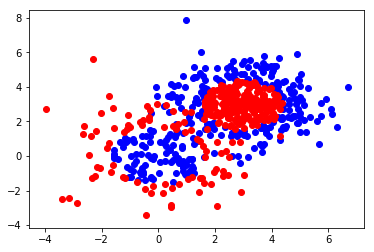

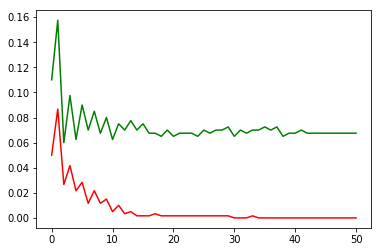

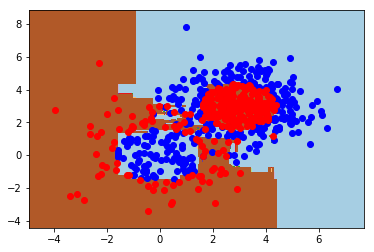

In [8]:
from sklearn.utils import resample

### Generate data
X,y = gen_data(1)
Xtest,X = np.split(X,[400])
ytest,y = np.split(y,[400])

Xblue = X[y==-1]
Xred = X[y==1]
plt.figure()
plt.scatter(Xblue[:,0],Xblue[:,1],c='b')
_=plt.scatter(Xred[:,0],Xred[:,1],c='r')

### Utility functions
def forest_predict(f,X):
    N = len(f)
    votes = np.zeros((X.shape[0],N))
    for i in range(N):
        votes[:,i] = f[i].predict(X)
    return np.sign(np.sum(votes,axis=1))

def forest_score(f,X,y):
    n=len(y)
    return np.sum(np.not_equal(forest_predict(f,X),y))/n

def plot_decision_boundary_forest(f, X, y):
    plot_step = 0.02
    x0_min, x0_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x1_min, x1_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx0, xx1 = np.meshgrid(np.arange(x0_min, x0_max, plot_step), np.arange(x1_min, x1_max, plot_step))
    yypred = forest_predict(f, np.c_[xx0.ravel(),xx1.ravel()])
    yypred = yypred.reshape(xx0.shape)
    plt.contourf(xx0, xx1, yypred, cmap=plt.cm.Paired)
    y_pred = forest_predict(f, X)
    Xblue_good = X[np.equal(y,-1)*np.equal(y,y_pred)]
    Xblue_bad  = X[np.equal(y,-1)*np.not_equal(y,y_pred)]
    Xred_good  = X[np.equal(y,1)*np.equal(y,y_pred)]
    Xred_bad   = X[np.equal(y,1)*np.not_equal(y,y_pred)]
    plt.scatter(Xblue_good[:,0],Xblue_good[:,1],c='b')
    plt.scatter(Xblue_bad[:,0],Xblue_bad[:,1],c='c',marker='v')
    plt.scatter(Xred_good[:,0],Xred_good[:,1],c='r')
    plt.scatter(Xred_bad[:,0],Xred_bad[:,1],c='m',marker='v')
    plt.show()
    
### Growing the forest
Nbootstrap = 51
forest = list()
tree_training_error = np.zeros(Nbootstrap)
tree_generalization_error = np.zeros(Nbootstrap)
forest_training_error = np.zeros(Nbootstrap)
forest_generalization_error = np.zeros(Nbootstrap)
for i in range(Nbootstrap):
    Xb, yb = resample(X, y)
    dt = tree.DecisionTreeClassifier(criterion='entropy')
    dt.fit(Xb,yb)
    forest.append(dt)
    # Eval
    tree_training_error[i]=1.-dt.score(X,y)
    tree_generalization_error[i] = 1.-dt.score(Xtest,ytest)
    forest_training_error[i]=forest_score(forest,X,y)
    forest_generalization_error[i]=forest_score(forest,Xtest,ytest)

### Display
print("Standard deviation of single tree training error: %g"%np.std(tree_training_error))
print("Standard deviation of single tree generalization error: %g"%np.std(tree_generalization_error))
print("Standard deviation of forest generalization error on last 15 iterations: %g"
      %np.std(forest_generalization_error[-15:]))
print("Average forest generalization error on last 15 iterations: %g"
      %np.mean(forest_generalization_error[-15:]))
print("Last forest generalization error on last 15 iterations: %g"%forest_generalization_error[-1])
plt.figure()
plt.plot(forest_training_error,c='r')
plt.plot(forest_generalization_error,c='g')
plt.figure()
plot_decision_boundary_forest(forest,X,y)

# <a id="sec3"></a> 3. Random Forests

Key idea: Grow a forest of trees by introducing randomness.

Randomness in:
-  Training subset selection (Bagging)
- Feature selection in each node

**Reminder: growing trees**

**FormTree($T$)**<br>
<ol>
<li> Find best split $(j, s)$ over $T$ // Which criterion?
<li> If $(j, s) = \emptyset$, 
    <ul>
    <li>  node = FormLeaf(T) // Which value for the leaf?
    </ul>
<li> Else
    <ul>
    <li> node = $(j, s)$
    <li> split $T$ according to $(j, s)$ into $(T1, T2)$
    <li> append FormTree($T1$) to node // Recursive call
    <li> append FormTree($T2$) to node
    </ul>
<li> Return node
</ol>

**New: random feature selection**

During step 1 (splitting) of FormTree(T), only search for the best split among a random subset of features.

Size of the subset has little importance. Usual choices:
- $\sqrt{p}$ in common cases
- 1 for fully randomized feature selection (still gives accurate results!)

**Reminder: Forest growth by Bagging of trees**

Example Set $T$, samples $x^1,\ldots, x^N$.<br>
For $b=1$ to $B$
1. Sample (with replacement) bootstrap replicate $T^b$ from $T$
2. $\varphi^b(x) \leftarrow$ FormTree($T^b$)

Return $\varphi_B(x) = \arg\max\limits_{y} \sum\limits_{b=1}^B I(\varphi^b(x) = y)$

<div class="alert alert-success">**Random Forests**
<ul>
<li> Fully grown trees
<li> + Random feature selection
<li> + Bagging
</ul>
</div>

**Margin guarantees?**

Margin of a random forest in $(x,y)$ = 
probability of classifying correctly $x$, minus probability of the most probable wrong class.<br>
$$m(x,y) = \mathbb{P}_\Theta\left(h\left(x,\Theta\right)=y\right) - \max\limits_{j\neq y}\mathbb{P}_\Theta\left(h\left(x,\Theta\right)=j\right)$$
As more trees are added, Random Forests converge to a bound in generalization error and do not overfit the training set.

**Alternatives to Random Forests?**
- Boosting (and the extension to the popular XGBoost algorithm),
- Extremely Randomized Trees.

Generalization error: 0.1


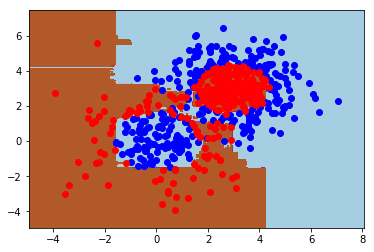

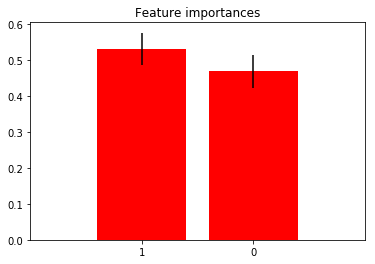

In [9]:
from sklearn.ensemble import RandomForestClassifier

### Generate data
X,y = gen_data(1)
Xtest,X = np.split(X,[400])
ytest,y = np.split(y,[400])

def plot_decision_boundary(f,X,y):
    plot_step = 0.02
    x0_min, x0_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x1_min, x1_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx0, xx1 = np.meshgrid(np.arange(x0_min, x0_max, plot_step), np.arange(x1_min, x1_max, plot_step))
    yypred = f.predict(np.c_[xx0.ravel(),xx1.ravel()])
    yypred = yypred.reshape(xx0.shape)
    plt.figure()
    plt.contourf(xx0, xx1, yypred, cmap=plt.cm.Paired)
    y_pred = f.predict(X)
    Xblue_good = X[np.equal(y,-1)*np.equal(y,y_pred)]
    Xblue_bad  = X[np.equal(y,-1)*np.not_equal(y,y_pred)]
    Xred_good  = X[np.equal(y,1)*np.equal(y,y_pred)]
    Xred_bad   = X[np.equal(y,1)*np.not_equal(y,y_pred)]
    plt.scatter(Xblue_good[:,0],Xblue_good[:,1],c='b')
    plt.scatter(Xblue_bad[:,0],Xblue_bad[:,1],c='c',marker='v')
    plt.scatter(Xred_good[:,0],Xred_good[:,1],c='r')
    plt.scatter(Xred_bad[:,0],Xred_bad[:,1],c='m',marker='v')
    plt.show()

rf = RandomForestClassifier(n_estimators=51, criterion='entropy')
rf.fit(X,y)

# Plot
print("Generalization error: %g"%(1.-rf.score(Xtest,ytest)))
plot_decision_boundary(rf,X,y)

# Feature importance
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
indices = np.argsort(importances)[::-1]
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

Random Forests provide an interesting **feature importance** estimation mechanism. Let's illustrate it.

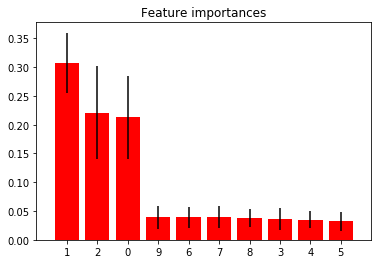

In [10]:
# A more demonstrative example
# Build a classification task using 10 features but only 3 informative ones.
X, y = datasets.make_classification(n_samples=1000,
                                    n_features=10,
                                    n_informative=3,
                                    n_redundant=0,
                                    n_repeated=0,
                                    n_classes=2,
                                    random_state=0,
                                    shuffle=False)
rf = RandomForestClassifier(n_estimators=51, criterion='entropy')
rf.fit(X,y)
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
indices = np.argsort(importances)[::-1]
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

# <a id="sec4"></a> 4. Examples

## <a id="sec4-1"></a> 4.1 Spam or ham?

In [11]:
from sys import path
path.append('../1 - Text data preprocessing')
import load_spam
spam_data = load_spam.spam_data_loader()
spam_data.load_data()
print("data loaded")

Xtrain, ytrain, Xtest, ytest = spam_data.split(2000)

data loaded


In [14]:
Xtrain.shape

(2000, 14279)

In [16]:
spam_RF = RandomForestClassifier(n_estimators=200, criterion='entropy')
spam_RF.fit(Xtrain,ytrain)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [17]:
spam_RF.score(Xtest.toarray(),ytest)

0.9664053751399776

In [12]:
# Compute cross-validation score
nb_trials = 20
score = []
for i in range(nb_trials):
    Xtrain, ytrain, Xtest, ytest = spam_data.shuffle_and_split(2000)
    spam_RF = RandomForestClassifier(n_estimators=200, criterion='entropy')
    spam_RF.fit(Xtrain,ytrain);
    score += [spam_RF.score(Xtest,ytest)]
    print('*', end='')
print(" done!")

print("Average generalization score:", np.mean(score))
print("Standard deviation:", np.std(score))

******************** done!
Average generalization score: 0.9735722284434492
Standard deviation: 0.00581229082748532


Let's see how the model behaves on raw word counts.

In [13]:
Xtrain, ytrain, Xtest, ytest = spam_data.split(2000, feat='wordcount')
spam_RF = RandomForestClassifier(n_estimators=200, criterion='entropy')
spam_RF.fit(Xtrain,ytrain)
spam_RF.score(Xtest,ytest)

0.9854423292273237

In [14]:
# Compute cross-validation score
nb_trials = 20
score = []
for i in range(nb_trials):
    Xtrain, ytrain, Xtest, ytest = spam_data.shuffle_and_split(2000, feat='wordcount')
    spam_RF = RandomForestClassifier(n_estimators=200, criterion='entropy')
    spam_RF.fit(Xtrain,ytrain);
    score += [spam_RF.score(Xtest,ytest)]
    print('*', end='')
print(" done!")

print("Average generalization score:", np.mean(score))
print("Standard deviation:", np.std(score))

******************** done!
Average generalization score: 0.9823068309070548
Standard deviation: 0.005187563190101006


Let's keep this last classifier and identify which are the misclassified emails.

In [15]:
# Retrain
Xtrain, ytrain, Xtest, ytest = spam_data.split(2000, feat="wordcount")
spam_RF = RandomForestClassifier(n_estimators=200, criterion='entropy')
spam_RF.fit(Xtrain,ytrain);

In [16]:
# Find misclassified examples
ypredict = spam_RF.predict(Xtest)
misclass = np.not_equal(ypredict, ytest)
Xmisclass = Xtest[misclass,:]
ymisclass = ytest[misclass]
misclass_indices = [i for i, j in enumerate(misclass) if j == True]
print("Misclassified messages indices:", misclass_indices)

Misclassified messages indices: [205, 206, 386, 402, 404, 413, 590, 594, 661, 726, 796, 808]


In [17]:
from sklearn.metrics import confusion_matrix
print("Confusion matrix:")
print(confusion_matrix(ytest, ypredict))

Confusion matrix:
[[742   1]
 [ 11 139]]


In [18]:
# Check some misclassified mails
index = misclass_indices[0]+2000
print("Prediction:", spam_RF.predict(spam_data.word_count[index,:]))
spam_data.print_email(index)
spam_RF.predict_proba(spam_data.word_count[index,:])

Prediction: [False]
email file: ../data/lingspam_public/bare/part9/spmsgc40.txt
email is a spam: True
Subject: for your urgent attention

if you ' re still so happy with your job , how come you ' re reading this email ? to search our database of over 5000 it , telecoms , finance and sales positions , check out www . taps . com / jobs , europe 's leading online recruitment website . taps . com is a free and confidential service .

Bag of words representation (17 words in dictionary):
{'tap': 2, 'recruitment': 1, 'urgent': 1, 'confidential': 1, 'job': 1, 'happy': 1, 'come': 1, 'search': 1, 'reading': 1, 'still': 1, 'leading': 1, 'finance': 1, 'free': 1, 'check': 1, 'service': 1, 'attention': 1, 'subject': 1}


array([[0.545, 0.455]])

In [25]:
print(spam_data.word_count.shape)
print(spam_data.tfidf.shape)

(2893, 14279)
(2893, 14279)


## 4.2 <a id="sec4-1"></a> NIST

In [19]:
from sklearn import datasets
%matplotlib inline
import matplotlib.pyplot as plt

digits = datasets.load_digits()
print(digits.data.shape)
print(digits.images.shape)
print(digits.target.shape)
print(digits.target_names)

X = digits.data
y = digits.target
Xtrain,Xtest = np.split(X,[1000])
ytrain,ytest = np.split(y,[1000])
#Xtrain = X[:1000,:]
#ytrain = y[:1000]
#Xtest = X[1000:,:]
#ytest = y[1000:]

#plt.gray();
#plt.matshow(digits.images[0]);
#plt.show();
#plt.matshow(digits.images[15]);
#plt.show();
#plt.matshow(digits.images[42]);
#plt.show();

from sklearn.utils import shuffle

def shuffle_and_split(X,y,n):
    X0,y0 = shuffle(X,y)
    Xtrain,Xtest = np.split(X0,[n])
    ytrain,ytest = np.split(y0,[n])
    return Xtrain, ytrain, Xtest, ytest

(1797, 64)
(1797, 8, 8)
(1797,)
[0 1 2 3 4 5 6 7 8 9]


In [20]:
print(Xtrain.shape)
print(ytrain.shape)
digits_rf = RandomForestClassifier(n_estimators=200, criterion='entropy')
digits_rf.fit(Xtrain,ytrain)
prediction = digits_rf.predict(Xtest)
#print("Training error:", np.sum(np.not_equal(prediction,ytest))/len(ytest))
print("Generalization error:", np.sum(np.not_equal(prediction,ytest))/len(ytest) )
print("Generalization score:", digits_rf.score(Xtest,ytest))
print("Confusion matrix:")
print(confusion_matrix(ytest, prediction))

(1000, 64)
(1000,)
Generalization error: 0.06398996235884567
Generalization score: 0.9360100376411543
Confusion matrix:
[[78  0  0  0  1  0  0  0  0  0]
 [ 0 73  0  0  0  1  0  0  0  6]
 [ 1  1 69  4  0  0  0  0  0  2]
 [ 0  1  1 65  0  2  0  2  8  0]
 [ 0  0  0  0 79  0  0  2  0  2]
 [ 0  0  0  0  0 81  1  0  0  0]
 [ 0  0  0  0  0  0 80  0  0  0]
 [ 0  0  0  0  0  0  0 78  2  0]
 [ 0  2  0  0  1  1  0  2 69  1]
 [ 0  0  0  2  0  3  0  0  2 74]]


In [22]:
# Compute cross-validation score
nb_trials = 20
score = []
for i in range(nb_trials):
    Xtrain, ytrain, Xtest, ytest = shuffle_and_split(X,y,1000)
    digits_rf = RandomForestClassifier(n_estimators=200, criterion='entropy')
    digits_rf.fit(Xtrain,ytrain)
    score += [digits_rf.score(Xtest,ytest)]
    print('*',end='')
print(" done!")

print("Average generalization score:", np.mean(score))
print("Standard deviation:", np.std(score))

******************** done!
Average generalization score: 0.9725219573400251
Standard deviation: 0.00428991743971864


Let's identify the misclassified images.

In [23]:
# Retrain
Xtrain = X[:1000,:]
ytrain = y[:1000]
Xtest = X[1000:,:]
ytest = y[1000:]
digits_rf = RandomForestClassifier(n_estimators=200, criterion='entropy')
digits_rf.fit(Xtrain,ytrain);

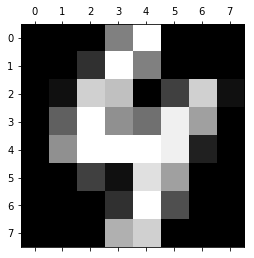

prediction on image number 1053 : [4]
correct label                : 4


In [25]:
# Examples
N = 1053
plt.gray();
plt.matshow(digits.images[N]) 
plt.show() 
x = digits.data[N,:]
print("prediction on image number", N, ":", digits_rf.predict([digits.data[N,:]]))
print("correct label                :", digits.target[N])

In [27]:
# Find misclassified examples
ypredict = digits_rf.predict(Xtest)
misclass = np.not_equal(ypredict, ytest)
Itest = digits.images[1000:,:]
Xmisclass = Xtest[misclass,:]
ymisclass = ytest[misclass]
Imisclass = Itest[misclass,:]

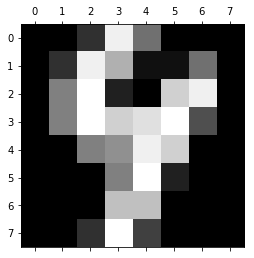

prediction on image number 3 : [9]
correct label                : 4


In [29]:
# Display misclassified examples
N = 3
plt.matshow(Imisclass[N]) 
plt.show() 
print("prediction on image number", N, ":", digits_rf.predict([Xmisclass[N,:]]))
print("correct label                :", ymisclass[N])